In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [48]:
import math

# Grayscale conversion 
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Canny detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

#apply Gaussian Blur 
def gaussian_blur(img, kernel_size):
     return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#Image mask     
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#average of lines 
def avg_lines(lines):
    try:
        x = [line[0] for line in lines]
        y = [line[1] for line in lines]
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y)[0]
        x = np.array(x)
        y = np.array(x * m + c).astype('int')
        return x,y,m,c
    except:
        print(x,y)
    
#draw lines
def draw_lines(img, lines, color=[255,0, 0], thickness=10):
    left_ms = []
    right_ms = []
    left_lines = []
    right_lines = []
    if lines == None:
        print("No lines")
        return
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = ((y2- y1)/(x2 - x1))
            if slope > 0:
                right_ms.append(slope)
                right_lines.append((x1,y1))
                right_lines.append((x2,y2))
            elif slope < 0:
                left_ms.append(slope)
                left_lines.append((x1,y1))
                left_lines.append((x2,y2))
    if len(right_lines) == 0 or len(left_lines) == 0:
        return;            
    right_x, right_y ,right_m, right_c =  avg_lines(right_lines)
    left_x, left_y, left_m, left_c = avg_lines(left_lines)
    top_y = min(min(left_y), min(right_y))
    left_top_x = int((top_y - left_c)/ (left_m))
    left_bottom_y = img.shape[0]
    left_bottom_x = int((left_bottom_y - left_c)/(left_m))
    cv2.line(img, (left_bottom_x, left_bottom_y), (left_top_x, top_y), color, thickness)
    top_y = min(min(left_y), min(right_y))
    right_top_x = int((top_y - right_c)/(right_m))
    right_bottom_y = img.shape[0]
    right_bottom_x = int((right_bottom_y - right_c) /(right_m))
    cv2.line(img, (right_top_x, top_y), (right_bottom_x, right_bottom_y), color, thickness)

#hough lines             
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
#return the weighted image (hough  +  oriignal)
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
        color_img = np.dstack((img,img,img))
        return cv2.addWeighted(initial_img, α, img, β, λ)

In [51]:
# Building the pipeline 
def process_image(image):
    gray_image = grayscale(image)
    blur_gray = gaussian_blur(gray_image,5)
    edges = canny(blur_gray,50,150)
    width  = image.shape[1]
    height = image.shape[0]
    vertices = np.array([[ (150, height) , (450,320), (490,320) , (width, height) ]], dtype = np.int32)
    masked_edges = region_of_interest(edges, vertices)
    lines = hough_lines(masked_edges, 1, np.pi/180 ,20, 5, 5)
    weight_img = weighted_img(lines, image)
    return weight_img

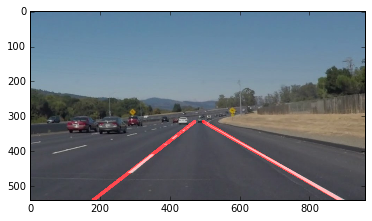

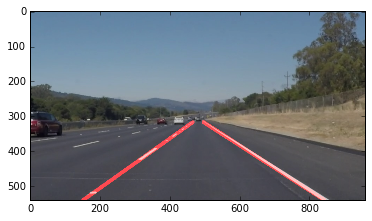

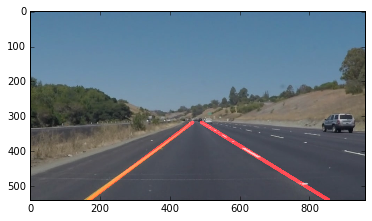

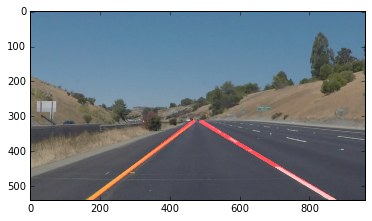

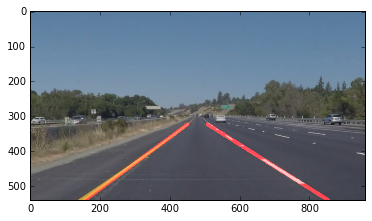

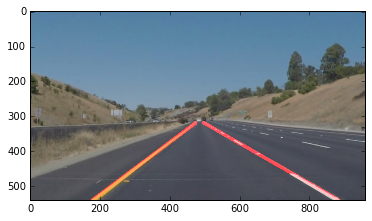

In [47]:
import os
list_images = os.listdir("test_images/")
for images in list_images:
    input_dir = "test_images/" + images
    image = mpimg.imread(input_dir) 
    weight_img = process_image(image)
    #output_dir = "test_images/result"+images
    plt.imshow(weight_img)
    plt.show()

In [52]:
white_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [00:15<00:00, 42.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 14.9 s, sys: 3.53 s, total: 18.4 s
Wall time: 16.3 s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))